In [1]:
import os
if "models" not in os.listdir("."):
    os.chdir("../..")

In [2]:
%load_ext autoreload
%autoreload 2
import penzai
import jax_smi
jax_smi.initialise_tracking()
from penzai import pz
pz.ts.register_as_default()
pz.ts.register_autovisualize_magic()
pz.enable_interactive_context()

In [3]:
from micrlhf.llama import LlamaTransformer
llama = LlamaTransformer.from_pretrained("models/gemma-2b-it.gguf", from_type="gemma", load_eager=True, device_map="tpu:0")

In [4]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("alpindale/gemma-2b")
tokenizer.padding_side = "right"

In [5]:
from sprint.icl_sfc_utils import Circuitizer

In [6]:
from sprint.task_vector_utils import load_tasks, ICLRunner
tasks = load_tasks()

fatal: destination path 'data/itv' already exists and is not an empty directory.


In [7]:
task_names = ["en_es", "antonyms", "person_profession"]
task_name = task_names[0]
task_name = "antonyms"

In [8]:
import json

with open("cleanup_results.jsonl") as f:
    lines = f.readlines()
    results = [json.loads(line) for line in lines]

In [9]:
def check_if_single_token(token):
    return len(tokenizer.tokenize(token)) == 1

task = tasks[task_name]

print(len(task))

# task = {
#     k:v for k,v in task.items() if check_if_single_token(k) and check_if_single_token(v)
# }

print(len(task))

pairs = list(task.items())

batch_size = 8 
n_shot=5
if task_name.startswith("algo"):
    n_shot = 8
max_seq_len = 128
seed = 10

prompt = "Follow the pattern:\n{}"

runner = ICLRunner(task_name, pairs, batch_size=batch_size, n_shot=n_shot, max_seq_len=max_seq_len, seed=seed, prompt=prompt, use_same_examples=False, use_same_target=False)


layers = list(range(5, 17))
circuitizer = Circuitizer(llama, tokenizer, runner, layers, prompt)

162
162
Setting up masks...


Running metrics...
Setting up RMS...


  0%|          | 0/18 [00:00<?, ?it/s]

Loading SAEs...


  0%|          | 0/12 [00:00<?, ?it/s]

Running node IEs...


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

In [10]:
llama.config.num_layers

18

In [11]:
second_task_name = "antonyms"

second_task = tasks[second_task_name]

second_task = {
    k:v for k,v in second_task.items() if check_if_single_token(k) and check_if_single_token(v)
}

second_pairs = list(second_task.items())

second_runner = ICLRunner(second_task_name, second_pairs, batch_size=4, n_shot=8, max_seq_len=max_seq_len, seed=seed, prompt=prompt, use_same_examples=True, use_same_target=True)

In [12]:
second_runner.train_pairs

[[('new', 'old'),
  ('dim', 'bright'),
  ('innocent', 'guilty'),
  ('dark', 'light'),
  ('even', 'odd'),
  ('go', 'stop'),
  ('junior', 'senior'),
  ('young', 'old')],
 [('new', 'old'),
  ('dim', 'bright'),
  ('innocent', 'guilty'),
  ('dark', 'light'),
  ('even', 'odd'),
  ('go', 'stop'),
  ('junior', 'senior'),
  ('smooth', 'rough')],
 [('new', 'old'),
  ('dim', 'bright'),
  ('innocent', 'guilty'),
  ('dark', 'light'),
  ('even', 'odd'),
  ('go', 'stop'),
  ('junior', 'senior'),
  ('new', 'old')],
 [('new', 'old'),
  ('dim', 'bright'),
  ('innocent', 'guilty'),
  ('dark', 'light'),
  ('even', 'odd'),
  ('go', 'stop'),
  ('junior', 'senior'),
  ('parent', 'child')]]

In [13]:
circuitizer.train_tokens[0].shape[0] - (circuitizer.train_tokens[0] == 0).sum()

70

In [14]:
circuitizer.train_tokens[0][64:69]

array([3978, 3582,  108, 8351, 3978])

In [17]:

layers = [10,11,12,13,14,15,16]
orig_metric = circuitizer.ablated_metric(llama).tolist()
zero_metric = circuitizer.run_ablated_metrics([100000], layers=layers)[0][0]

print(orig_metric, zero_metric)

  0%|          | 0/1 [00:00<?, ?it/s]

-20.0 -105.0


In [27]:
import numpy as np
# thresholds = np.linspace(0, 1e-4, 100)
# thresholds = np.linspace(1.4 * 1e-4, 1.45 * 1e-4, 200)
thresholds = np.logspace(-5, -1, 150)
topks = [4, 6, 12, 16, 24, 32]

inverse = False
do_abs = False
mean_ablate = False
average_over_positions = False


ablated_metrics, n_nodes_counts = circuitizer.run_ablated_metrics(thresholds, inverse=inverse, 
                                                                  do_abs=do_abs, mean_ablate=mean_ablate, 
                                                                  average_over_positions=average_over_positions,
                                                                  token_prefix=None, layers=layers)

faithfullness = np.array(ablated_metrics)
faithfullness = (faithfullness - zero_metric) / (orig_metric - zero_metric)



# target_metric = (max(ablated_metrics) - min(ablated_metrics)) * 0.95 + min(ablated_metrics)
# target_threshold = [threshold for threshold, metric in reversed(list(zip(thresholds, ablated_metrics))) if metric > target_metric][0]

  0%|          | 0/150 [00:00<?, ?it/s]

In [15]:
target_metric = (max(ablated_metrics) - min(ablated_metrics)) * 0.95 + min(ablated_metrics)

print(target_metric)
target_threshold = [threshold for threshold, metric in list(zip(thresholds, ablated_metrics)) if metric > target_metric][0]
print(target_threshold)

-0.6205566406250007
1e-07


In [78]:
ablated_metrics[113:126]

[-6.25,
 -6.21875,
 -5.15625,
 -3.90625,
 -3.703125,
 -3.765625,
 -3.625,
 -3.640625,
 -3.296875,
 -3.296875,
 -3.296875,
 -3.125,
 -2.421875]

In [28]:
import matplotlib.pyplot as plt
import plotly.express as px

# plt.plot([max(n_nodes_counts) - x for x in n_nodes_counts], ablated_metrics)
# plt.plot(thresholds, ablated_metrics)
# plt.plot(thresholds, ablated_metrics)
# plt.plot(n_nodes_counts, ablated_metrics)
# plt.plot(thresholds, n_nodes_counts)
# plt.xscale("log")
# plt.plot(n_nodes_counts)

# px.line(x=list(range(len(ablated_metrics))), y=ablated_metrics)
# fig = px.line(x=thresholds, y=ablated_metrics)
# fig.update_xaxes(type="log", exponentformat="power")

fig = px.line(x=n_nodes_counts, y=faithfullness, title=f"inverse={inverse}, abs={do_abs}, mean={mean_ablate}, aop={average_over_positions}, layers={layers}")
fig.update_xaxes(title="Number of nodes")
fig.update_yaxes(title="Faithfullness")

fig


In [16]:
import matplotlib.pyplot as plt
import plotly.express as px

# plt.plot([max(n_nodes_counts) - x for x in n_nodes_counts], ablated_metrics)
# plt.plot(thresholds, ablated_metrics)
# plt.plot(thresholds, ablated_metrics)
# plt.plot(n_nodes_counts, ablated_metrics)
# plt.plot(thresholds, n_nodes_counts)
# plt.xscale("log")
# plt.plot(n_nodes_counts)

# px.line(x=list(range(len(ablated_metrics))), y=ablated_metrics)
# fig
fig = px.line(x=thresholds, y=ablated_metrics)
fig.update_xaxes(type="log", exponentformat="power")
fig

# px.line(x=n_nodes_counts, y=ablated_metrics)


In [16]:
import matplotlib.pyplot as plt
import plotly.express as px

# plt.plot([max(n_nodes_counts) - x for x in n_nodes_counts], ablated_metrics)
# plt.plot(thresholds, ablated_metrics)
# plt.plot(thresholds, ablated_metrics)
# plt.plot(n_nodes_counts, ablated_metrics)
# plt.plot(thresholds, n_nodes_counts)
# plt.xscale("log")
# plt.plot(n_nodes_counts)

# px.line(x=list(range(len(ablated_metrics))), y=ablated_metrics)
# fig
# fig = px.line(x=thresholds, y=ablated_metrics)
# fig.update_xaxes(type="log", exponentformat="power")
# fig

px.line(x=n_nodes_counts, y=ablated_metrics)


In [47]:
from micrlhf.llama import LlamaBlock

block = llama.select().at_instances_of(LlamaBlock).pick_nth_selected(12).get()
block

LlamaBlock( # Sequential
  #╭┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄╮
  # Broken handler refs: [HandledSideInputRef(handler_id='WithSideInputsFromInputTuple_91b22', tag='positions'), HandledSideInputRef(handler_id='WithSideInputsFromInputTuple_91b22', tag='attn_mask')]
  #╰┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄╯
  sublayers=[
    WithConstantSideInputsNonPytree(
      handler_id='WithConstantSideInputsNonPytree_febf8',
      body=ConstrainedSharding(mesh=HandledSideInputRef(handler_id='WithConstantSideInputsNonPytree_febf8', tag='mesh'), axis_name_to_mesh_name=HandledSideInputRef(handler_id='WithConstantSideInputsNonPytree_febf8', tag='axis_name_to_mesh_name')),
      side_inputs={'axis_name_to_mesh_name': {'neurons': 'mp', 'kv_heads': 'mp', 'seq': 'sp', 'batch': 'dp', 'sp': 'sp', 'mp': 'mp', 'dp': 'dp'}, 'mesh': Mesh(device_ids=array([[[0]]]), axis_names=('dp', 'sp', 'mp'))},
    ),
    Residual(
      delta=Sequential(sublayers=[RMSLayerNorm(sublayers=[RMSStandardize(across=('embedding',), epsilon=<jax.Array(9.98378e-07, dtype=bfloat16)>), Linear(weights=Parameter(value=<NamedArray bfloat16(| embedding:2048) ≈2.3 ±0.83 [≥0.32, ≤4.7] nonzero:2_048 (wrapping jax.Array)>, name='blocks.12.pre_attn_norm.scale.weights'), in_axis_names=(), out_axis_names=())]), CastToDType(dtype=jax.numpy.bfloat16), LlamaAttention(input_to_query=Sequential(sublayers=[Linear(weights=Parameter(value=<NamedArray bfloat16(| embedding:2048, kv_heads:1, q_rep:8, projection:256) ≈-1.2e-06 ±0.0089 [≥-0.096, ≤0.1] zero:33_265 nonzero:4_161_039 (wrapping jax.Array)>, name='blocks.12.attn.query.weights'), in_axis_names=('embedding',), out_axis_names=('kv_heads', 'q_rep', 'projection')), ApplyRoPE(embedding_axis='projection', max_wavelength=10000, positions=HandledSideInputRef(handler_id='WithSideInputsFromInputTuple_91b22', tag='positions')), ConstantRescale(by=<jax.Array(0.0625, dtype=bfloat16)>)]), input_to_key=Sequential(sublayers=[Linear(weights=Parameter(value=<NamedArray bfloat16(| embedding:2048, kv_heads:1, projection:256) ≈-6.2e-06 ±0.0099 [≥-0.11, ≤0.12] zero:4_173 nonzero:520_115 (wrapping jax.Array)>, name='blocks.12.attn.key.weights'), in_axis_names=('embedding',), out_axis_names=('kv_heads', 'projection')), ApplyRoPE(embedding_axis='projection', max_wavelength=10000, positions=HandledSideInputRef(handler_id='WithSideInputsFromInputTuple_91b22', tag='positions')), CastToDType(dtype=jax.numpy.bfloat16)]), input_to_value=Sequential(sublayers=[Linear(weights=Parameter(value=<NamedArray bfloat16(| embedding:2048, kv_heads:1, projection:256) ≈-1.2e-05 ±0.0099 [≥-0.056, ≤0.056] zero:4_514 nonzero:519_774 (wrapping jax.Array)>, name='blocks.12.attn.value.weights'), in_axis_names=('embedding',), out_axis_names=('kv_heads', 'projection')), CastToDType(dtype=jax.numpy.bfloat16)]), query_key_to_attn=Sequential(sublayers=[NamedEinsum(input_axes=({'seq': 'tq', 'kv_heads': 'h', 'q_rep': 'r', 'projection': 'p'}, {'seq': 'tkv', 'kv_heads': 'h', 'projection': 'p'}), output_axes={'seq': 'tq', 'kv_heads': 'h', 'q_rep': 'r', 'kv_seq': 'tkv'}), ApplyAttentionMask(mask=HandledSideInputRef(handler_id='WithSideInputsFromInputTuple_91b22', tag='attn_mask'), masked_out_value=<jax.Array(-3.38953e+38, dtype=bfloat16)>), Softmax(axes='kv_seq')]), attn_value_to_output=Sequential(sublayers=[NamedEinsum(input_axes=({'seq': 'tq', 'kv_heads': 'h', 'q_rep': 'r', 'kv_seq': 'tkv'}, {'seq': 'tkv', 'kv_heads': 'h', 'projection': 'p'}), output_axes={'seq': 'tq', 'kv_heads': 'h', 'q_rep': 'r', 'projection': 'p'}), Linear(weights=Parameter(value=<NamedArray bfloat16(| kv_heads:1, q_rep:8, projection:256, embedding:2048) ≈-1.1e-06 ±0.0085 [≥-0.23, ≤0.23] zero:31_369 nonzero:4_162_935 (wrapping jax.Array)>, name='blocks.12.attn.output.weights'), in_axis_names=('kv_heads', 'q_rep', 'projection'), out_axis_names=('embedding',))]))]),
    ),
    WithConstantSideInputsNonPytree(handler_id='WithConstantSideInputsNonPytree_febf8', body=ConstrainedSharding(mesh=HandledSideInputRef(handler_id='

In [43]:
import matplotlib.pyplot as plt
import plotly.express as px

# plt.plot([max(n_nodes_counts) - x for x in n_nodes_counts], ablated_metrics)
# plt.plot(thresholds, ablated_metrics)
# plt.plot(thresholds, ablated_metrics)
# plt.plot(n_nodes_counts, ablated_metrics)
# plt.plot(thresholds, n_nodes_counts)
# plt.xscale("log")
# plt.plot(n_nodes_counts)

fig = px.line(x=list(range(len(ablated_metrics))), y=ablated_metrics)
fig
# fig = px.line(x=thresholds, y=ablated_metrics)
# fig.update_xaxes(type="log", exponentformat="power")
# fig

# px.line(x=n_nodes_counts, y=ablated_metrics)


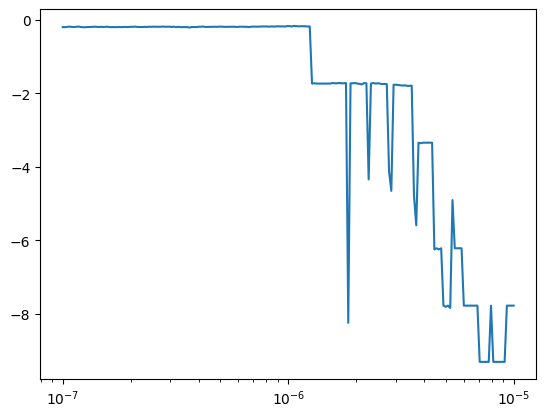

In [27]:
import matplotlib.pyplot as plt
import plotly.express as px

# plt.plot([max(n_nodes_counts) - x for x in n_nodes_counts], ablated_metrics)
# plt.plot(thresholds, ablated_metrics)
plt.plot(thresholds, ablated_metrics)
# plt.plot(n_nodes_counts, ablated_metrics)
# plt.plot(thresholds, n_nodes_counts)
plt.xscale("log")
# plt.plot(n_nodes_counts)


# px.line(x=n_nodes_counts, y=ablated_metrics)

[<matplotlib.lines.Line2D at 0x7fa81018e650>]

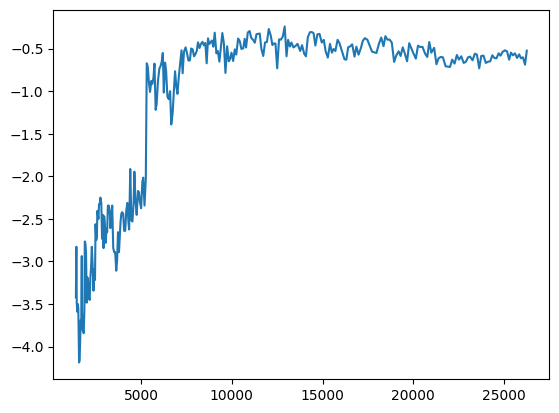

In [13]:
import matplotlib.pyplot as plt

# plt.plot([max(n_nodes_counts) - x for x in n_nodes_counts], ablated_metrics)
# plt.plot(thresholds, ablated_metrics)
# plt.plot(thresholds, ablated_metrics)
plt.plot(n_nodes_counts, ablated_metrics)
# plt.plot(thresholds, n_nodes_counts)
# plt.xscale("log")

[<matplotlib.lines.Line2D at 0x7f45c4d70eb0>]

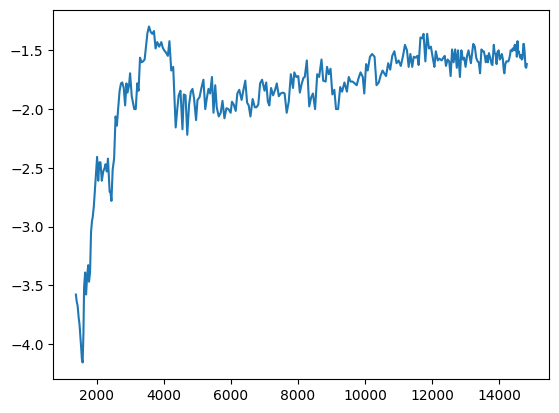

In [43]:
import matplotlib.pyplot as plt

# plt.plot([max(n_nodes_counts) - x for x in n_nodes_counts], ablated_metrics)
# plt.plot(thresholds, ablated_metrics)
# plt.plot(thresholds, ablated_metrics)
plt.plot(n_nodes_counts, ablated_metrics)
# plt.plot(thresholds, n_nodes_counts)
# plt.xscale("log")

[<matplotlib.lines.Line2D at 0x7f8c737d7d00>]

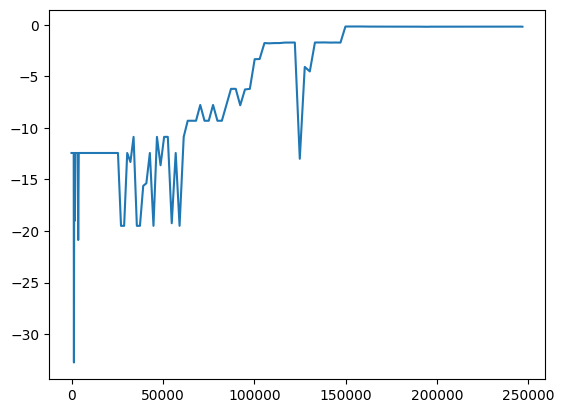

In [18]:
import matplotlib.pyplot as plt

# plt.plot([max(n_nodes_counts) - x for x in n_nodes_counts], ablated_metrics)
# plt.plot(thresholds, ablated_metrics)
plt.plot(n_nodes_counts, ablated_metrics)
# plt.plot(n_nodes_counts, ablated_metrics)
# plt.xscale("log")

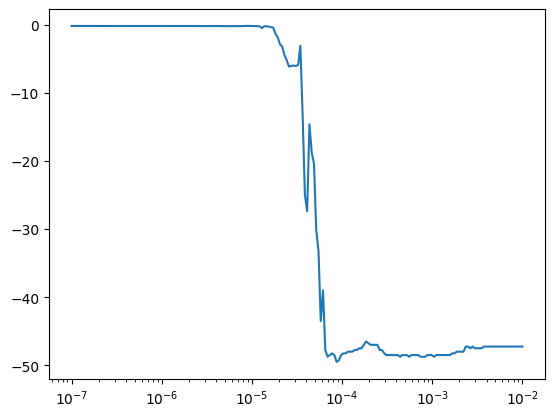

In [23]:
import matplotlib.pyplot as plt

# plt.plot([max(n_nodes_counts) - x for x in n_nodes_counts], ablated_metrics)
plt.plot(thresholds, ablated_metrics)
# plt.plot(n_nodes_counts, ablated_metrics)
# plt.plot(n_nodes_counts, ablated_metrics)
plt.xscale("log")

In [23]:
mask[0]

# jax.Array bool(127,) true:59 false:68
  Array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True], dtype=bool)

In [17]:
max(ablated_metrics), min(ablated_metrics)

(-17.875, -1016.0)

In [33]:
circuitizer.ablated_metric(llama)

<jax.Array(-20, dtype=bfloat16)>

In [ ]:
from tqdm.auto import tqdm

ams = []

for layer in tqdm(circuitizer.layers):
    ablated_metrics, n_nodes_counts = circuitizer.run_ablated_metrics(thresholds, inverse=True, sae_types=["attn_out"], layers=[layer])
    ams.append(ablated_metrics)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
[min(x) for x in ams]

[-1.609375,
 -1.5234375,
 -1.5234375,
 -1.5390625,
 -1.5859375,
 -1.6484375,
 -1.75,
 -3.28125,
 -1.5390625,
 -1.6328125,
 -1.546875]

: 

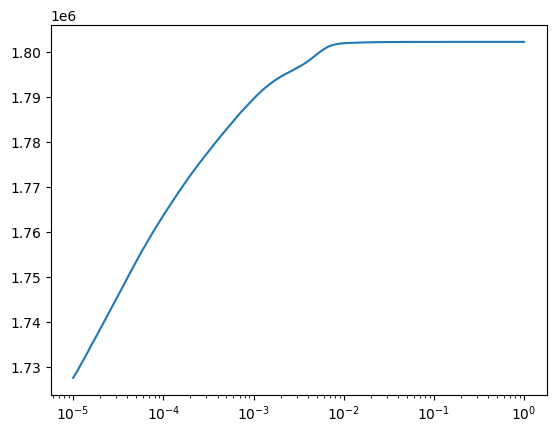

In [ ]:
plt.plot(thresholds, n_nodes_counts)
plt.xscale("log")

In [ ]:
ablated_metrics[22]

-5.25

In [43]:
selected_threshold

0.03292971255097151

In [44]:
from tqdm.auto import tqdm

layers = circuitizer.layers
selected_threshold = target_threshold



mask_resid, _ = circuitizer.mask_ie(circuitizer.ie_resid[12], selected_threshold, None, do_abs=False, average_over_positions=False, token_prefix=68)


    

In [77]:
mean_ie = circuitizer.ie_resid[12].mean(0)

In [83]:
import jax

jax.lax.top_k(circuitizer.ie_resid[10].mean(0)[65], 10)

# mean_ie[67].max()

[# jax.Array float32(10,) ≈0.018 ±0.006 [≥0.0091, ≤0.027] nonzero:10
   Array([0.02726172, 0.02616928, 0.02356915, 0.01795517, 0.01743256,
          0.01719484, 0.01396573, 0.01238095, 0.01110678, 0.00913343],      dtype=float32)
 ,
 # jax.Array int32(10,) [≥1_163, ≤31_539] nonzero:10
   Array([24942,  4338, 31539,  1163, 29472,  5703, 13025,  7666, 20768,
          17235], dtype=int32)
 ]

In [52]:
circuitizer.train_tokens[0, 64]

3978

In [21]:
circuitizer.ie_resid[12][0, 68, 11618]

<jax.Array(0.0752492, dtype=float32)>

In [51]:
mean_ie[64, 11618]

<jax.Array(-0.00475395, dtype=float32)>

In [47]:
mask_resid["arrow"].sum(axis=-1)

# jax.Array int32(128,) [≥0, ≤32_768] zero:127 nonzero:1
  Array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0, 32768,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0], dtype=int32)

In [42]:
from tqdm.auto import tqdm

layers = circuitizer.layers
layers = [15,16]
selected_threshold = target_threshold


ablation_masks = {}

for layer in tqdm(layers):
    mask_attn_out, _ = circuitizer.mask_ie(circuitizer.ie_attn[layer], selected_threshold, None, do_abs=True, average_over_positions=False, inverse=True)
    mask_resid, _ = circuitizer.mask_ie(circuitizer.ie_resid[layer], selected_threshold, None, do_abs=True, average_over_positions=False, inverse=True)

    # print(mask_resid["arrow"].shape)

    # break

    try:
        mask_transcoder, _ = circuitizer.mask_ie(circuitizer.ie_transcoder[layer], selected_threshold, None, do_abs=True, average_over_positions=False, inverse=True)
    except KeyError:
        mask_transcoder = None

    ablation_masks[layer] = {
        "attn_out": mask_attn_out,
        "resid": mask_resid,
        "transcoder": mask_transcoder
    }

  0%|          | 0/2 [00:00<?, ?it/s]

In [96]:
from tqdm.auto import tqdm

layers = circuitizer.layers
layers = [8,9,10,11,12,13, 14]
selected_threshold = target_threshold

idx_1 = 76
idx_2 = 94

ablation_masks = {}

inverse = False
do_abs = True
avg_over = True

for layer in tqdm(layers):
    mask_attn_out, _ = circuitizer.mask_ie(circuitizer.ie_attn[layer], thresholds[idx_2], None, do_abs=do_abs, average_over_positions=avg_over, inverse=inverse)
    mask_attn_out_2, _ = circuitizer.mask_ie(circuitizer.ie_attn[layer], thresholds[idx_1], None, do_abs=do_abs, average_over_positions=avg_over, inverse=inverse)


    mask_attn_out = {
        k: (v.astype(np.int32) - mask_attn_out_2[k].astype(np.int32)) != 0 for k,v in mask_attn_out.items()
    }

    mask_resid, _ = circuitizer.mask_ie(circuitizer.ie_resid[layer], thresholds[idx_2], None, do_abs=do_abs, average_over_positions=avg_over, inverse=inverse)
    mask_resid_2, _ = circuitizer.mask_ie(circuitizer.ie_resid[layer], thresholds[idx_1], None, do_abs=do_abs, average_over_positions=avg_over, inverse=inverse)


    mask_resid = {
        k: (v.astype(np.int32) - mask_resid_2[k].astype(np.int32)) != 0 for k,v in mask_resid.items()
    }



    # print(mask_resid["arrow"].sum())

    # print(mask_resid["arrow"].shape)

    # break

    try:
        mask_transcoder, _ = circuitizer.mask_ie(circuitizer.ie_transcoder[layer], thresholds[idx_2], None, do_abs=do_abs, average_over_positions=avg_over, inverse=inverse)
        mask_transcoder_2, _ = circuitizer.mask_ie(circuitizer.ie_transcoder[layer], thresholds[idx_1], None, do_abs=do_abs, average_over_positions=avg_over, inverse=inverse)

        mask_transcoder = {
            k: (v.astype(np.int32) - mask_transcoder_2[k].astype(np.int32)) != 0 for k,v in mask_transcoder.items()
        }
    except KeyError:
        mask_transcoder = None

    ablation_masks[layer] = {
        "attn_out": mask_attn_out,
        "resid": mask_resid,
        "transcoder": mask_transcoder
    }

  0%|          | 0/7 [00:00<?, ?it/s]

In [67]:
ablation_masks[15]["resid"]["arrow"].sum()

<jax.Array(2, dtype=int32)>

In [97]:
ablated_nodes = []
n_nodes = 0

for layer, masks in ablation_masks.items():
    for mask_type, mask in masks.items():
        if mask is not None:
            for token_type, mask in mask.items():
                    deleted = (1 - mask)
                    deleted = mask
                    n_nodes += mask.sum()
                    
                    node_ids = np.where(deleted)

                    # print(node_ids)

                    # for p, i in zip(*node_ids):
                    #     ablated_nodes.append((layer, mask_type, token_type, p, i))
                    for i in node_ids[0]:
                        ablated_nodes.append((layer, mask_type, token_type, 0, i))
                    

n_nodes

<jax.Array(13, dtype=int32)>

In [51]:
runner.train_pairs

[[('more', 'less'),
  ('new', 'old'),
  ('accept', 'reject'),
  ('defend', 'attack'),
  ('odd', 'even'),
  ('dark', 'light'),
  ('inner', 'outer'),
  ('build', 'destroy'),
  ('deny', 'admit'),
  ('first', 'last'),
  ('rude', 'polite'),
  ('fake', 'real'),
  ('male', 'female'),
  ('early', 'late'),
  ('above', 'below'),
  ('best', 'worst')]]

In [73]:
ablated_nodes

[(15, 'resid', 'arrow', 68, 21202),
 (15, 'resid', 'arrow', 68, 29265),
 (15, 'transcoder', 'arrow', 68, 20879)]

In [98]:
typed_ies = {
    "r": circuitizer.ie_resid,
    "a": circuitizer.ie_attn,
    "t": circuitizer.ie_transcoder,
}

for node in ablated_nodes:
    layer, sae_type, token_type, pos, node_id = node
    ies = typed_ies[sae_type[0]][layer]
    # masked_ies = circuitizer.mask_average(ies, token_type, average_over_positions=False)
    # print(node, masked_ies[pos, node_id])
    masked_ies = circuitizer.mask_average(ies, token_type, average_over_positions=True)
    print(node, masked_ies[node_id])
    


(8, 'resid', 'output', 0, 27119) 0.00014202534
(8, 'resid', 'output', 0, 31079) -0.00014235983
(8, 'resid', 'newline', 0, 24856) -0.00014220773
(9, 'transcoder', 'output', 0, 2860) -0.00014234715
(10, 'resid', 'arrow', 0, 14646) 0.00014227042
(11, 'attn_out', 'arrow', 0, 3988) 0.00014206511
(11, 'attn_out', 'arrow', 0, 4734) 0.00014196264
(11, 'resid', 'input', 0, 12020) 0.00014200383
(11, 'resid', 'output', 0, 3312) -0.00014213844
(11, 'transcoder', 'arrow', 0, 6911) 0.00014235041
(13, 'attn_out', 'arrow', 0, 969) 0.00014226779
(13, 'transcoder', 'arrow', 0, 7217) 0.00014232134
(14, 'resid', 'output', 0, 1536) -0.00014216323


In [92]:
ablated_nodes_1 = ablated_nodes

In [99]:
typed_ies = {
    "r": circuitizer.ie_resid,
    "a": circuitizer.ie_attn,
    "t": circuitizer.ie_transcoder,
}

for node in ablated_nodes_1:
    layer, sae_type, token_type, pos, node_id = node
    ies = typed_ies[sae_type[0]][layer]
    # masked_ies = circuitizer.mask_average(ies, token_type, average_over_positions=False)
    # print(node, masked_ies[pos, node_id])
    masked_ies = circuitizer.mask_average(ies, token_type, average_over_positions=True)
    print(node, masked_ies[node_id])
    

(9, 'resid', 'output', 0, 3985) -0.00014190501
(9, 'transcoder', 'output', 0, 19639) -0.00014189054
(12, 'transcoder', 'input', 0, 21237) 0.00014190163
(12, 'transcoder', 'arrow', 0, 13379) 0.00014190402


In [103]:
ablated_directions = []

for layer, sae_type, token_type, pos, node_id in ablated_nodes:
    sae = circuitizer.saes[(layer, sae_type)]
    direction = sae["W_dec"][node_id]

    ablated_directions.append(direction)

ablated_directions = np.array(ablated_directions)

ablated_directions_1 = []

for layer, sae_type, token_type, pos, node_id in ablated_nodes_1:
    sae = circuitizer.saes[(layer, sae_type)]
    direction = sae["W_dec"][node_id]

    ablated_directions_1.append(direction)

ablated_directions_1 = np.array(ablated_directions_1)

In [104]:
cosine_similarities = np.dot(ablated_directions, ablated_directions_1.T)

px.imshow(cosine_similarities)

In [91]:
[x for x in runner.train_pairs if "sharp" in str(x)]

[[('quiet', 'loud'),
  ('wet', 'dry'),
  ('on', 'off'),
  ('big', 'small'),
  ('push', 'pull'),
  ('loose', 'tight'),
  ('urban', 'rural'),
  ('soft', 'hard'),
  ('guilty', 'innocent'),
  ('fun', 'boring'),
  ('rough', 'smooth'),
  ('positive', 'negative'),
  ('increase', 'decrease'),
  ('blunt', 'sharp'),
  ('arrive', 'depart'),
  ('complex', 'simple')],
 [('loud', 'quiet'),
  ('on', 'off'),
  ('male', 'female'),
  ('divide', 'unite'),
  ('gentle', 'rough'),
  ('front', 'back'),
  ('lead', 'follow'),
  ('rough', 'smooth'),
  ('right', 'wrong'),
  ('new', 'old'),
  ('disappear', 'appear'),
  ('soft', 'hard'),
  ('receive', 'send'),
  ('happy', 'sad'),
  ('go', 'stop'),
  ('sharp', 'dull')],
 [('horizontal', 'vertical'),
  ('wet', 'dry'),
  ('inside', 'outside'),
  ('straight', 'curvy'),
  ('wide', 'narrow'),
  ('sharp', 'dull'),
  ('left', 'right'),
  ('back', 'front'),
  ('rare', 'common'),
  ('on', 'off'),
  ('gentle', 'rough'),
  ('tiny', 'huge'),
  ('dim', 'bright'),
  ('rough', 'smooth'),
  ('forget', 'remember'),
  ('strong', 'weak')]]

In [ ]:
len(ablated_nodes)

206

In [ ]:
removed_features_attn_mask = mask_attn_out_2["arrow"].astype(np.int32) -  mask_attn_out_1["arrow"].astype(np.int32)
removed_features_attn_mask = removed_features_attn_mask == 1

In [ ]:
removed_features_attn_mask.sum()

<jax.Array(57, dtype=int32)>

In [ ]:
removed_features_attn = circuitizer.saes[(12, "resid")]["W_dec"][removed_features_attn_mask]

In [ ]:
removed_features_attn = removed_features_attn / np.linalg.norm(removed_features_attn, axis=1, keepdims=True)

pairwise_sims = removed_features_attn @ removed_features_attn.T



In [ ]:
%pip install -U kaleido

/usr/lib/python3.10/pty.py:89: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 14.9 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import plotly.express as px
import plotly.io as pio

fig = px.imshow(pairwise_sims, width=800, height=800)
# pio.write_image(fig, "pairwise_sims.png")

fig

In [ ]:
features = [9790, 12605, 13458, 11491, 18803, 2931, 11618, 26987, 5679, 15554, 26594]

In [ ]:
from sprint.icl_sfc_utils import AblatedModule
layer = 12
mask_name = "arrow"

In [ ]:
task_results = [result for result in results if result["task"] == task_name]

In [ ]:
len(task_results)

8

In [ ]:
import jax.numpy as jnp

layer_masks = {}

resid = circuitizer.saes[(12, "resid")]


for r in task_results:
    layer = r["layer"]
    w = np.array(r["weights"])
    f_ids = jnp.nonzero(w * (w > 0))

    feature = features[0]

    mask = np.ones(resid["W_dec"].shape[0])
    mask[f_ids] = 0

    mask = jnp.array(mask)

    masks = {
        k: mask for k in circuitizer.masks
    }

    # masks[mask_name] = mask

    layer_masks[layer] = masks



In [ ]:
from micrlhf.llama import LlamaBlock

llama_ablated = llama

for layer, masks in layer_masks.items():
    block_selection = llama_ablated.select().at_instances_of(LlamaBlock).pick_nth_selected(layer)

    def converter(block):
        block = block.select().at_instances_of(LlamaBlock).apply(lambda x: pz.nn.Sequential([AblatedModule.wrap(resid, masks, circuitizer.masks), x]))    
        return block

    llama_ablated = block_selection.apply(converter)

In [ ]:
print(circuitizer.ablated_metric(llama_ablated))
print(circuitizer.ablated_metric(llama))

-1.6610659
-1.40625


In [ ]:
circuitizer.run_ablated_metrics([-1, 0, target_threshold])

  0%|          | 0/3 [00:00<?, ?it/s]

([-1.3984375, -1.4296875, -1.0703125], [5242880, 200719, 118202])

In [ ]:
import matplotlib.pyplot as plt

ablated_metrics[:40]

[-1.2734375,
 -1.28125,
 -1.2578125,
 -1.265625,
 -1.171875,
 -1.078125,
 -1.1015625,
 -1.1328125,
 -1.078125,
 -1.1015625,
 -1.1796875,
 -1.171875,
 -1.1953125,
 -1.2109375,
 -1.1875,
 -1.1875,
 -1.1875,
 -1.1796875,
 -1.15625,
 -1.0546875,
 -1.0546875,
 -1.046875,
 -1.078125,
 -1.1328125,
 -1.09375,
 -1.0625,
 -1.1171875,
 -1.140625,
 -1.1015625,
 -1.140625,
 -1.1171875,
 -1.1796875,
 -1.25,
 -1.171875,
 -1.140625,
 -1.09375,
 -1.0078125,
 -1.03125,
 -1.1015625,
 -1.1015625]

In [ ]:
logits = llama(circuitizer.llama_inputs)

In [ ]:
logits = logits.unwrap("batch", "seq", "vocabulary")

In [ ]:
logits = logits.argmax(-1)

In [ ]:
logits = logits[:, :-1]

res = logits == circuitizer.train_tokens[:, 1:]

In [ ]:
answer_mask = circuitizer.train_tokens[:, 1:] == 3978
answer_mask = np.roll(answer_mask, 1, axis=1)

In [ ]:
(res * answer_mask).sum() / answer_mask.sum()

<jax.Array(0.7265625, dtype=float32)>